# Dataset preparation for ControlNet training with MediaPipe and Hugging Face

_By: MediaPipe team (Google), Diffusers team (Hugging Face)_

This notebook provides an end-to-end example of preparing a dataset that is compatible with [ControlNet training](https://github.com/huggingface/diffusers/tree/main/examples/controlnet) using MediaPipe and Hugging Face. Specifically, in this notebook, we

* Load the [`horses_or_humans` dataset](https://www.tensorflow.org/datasets/catalog/horses_or_humans) using TensorFlow Datasets.
* Prepare conditioning images from the original images of the dataset using [MediaPipe Pose Landmark Detection](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker). 
* Generate captions of the original images using BLIP-2 using [🤗 Transformers](https://huggingface.co/docs/transformers).
* Prepare the final dataset using [🤗 Datasets](https://huggingface.co/docs/datasets) and push it to the Hugging Face Hub. 

Let's get started!

## Install libraries

In [1]:
!pip install -q mediapipe datasets transformers accelerate

## Load the dataset

After we load the `train` set of the dataset, we filter it to only have the `humans` labels. 

In [1]:
import tensorflow_datasets as tfds

dataset = tfds.load("horses_or_humans", split="train")
dataset = dataset.filter(lambda x: x["label"] == 1)  # 1 for humans

Let's visualize a few samples.

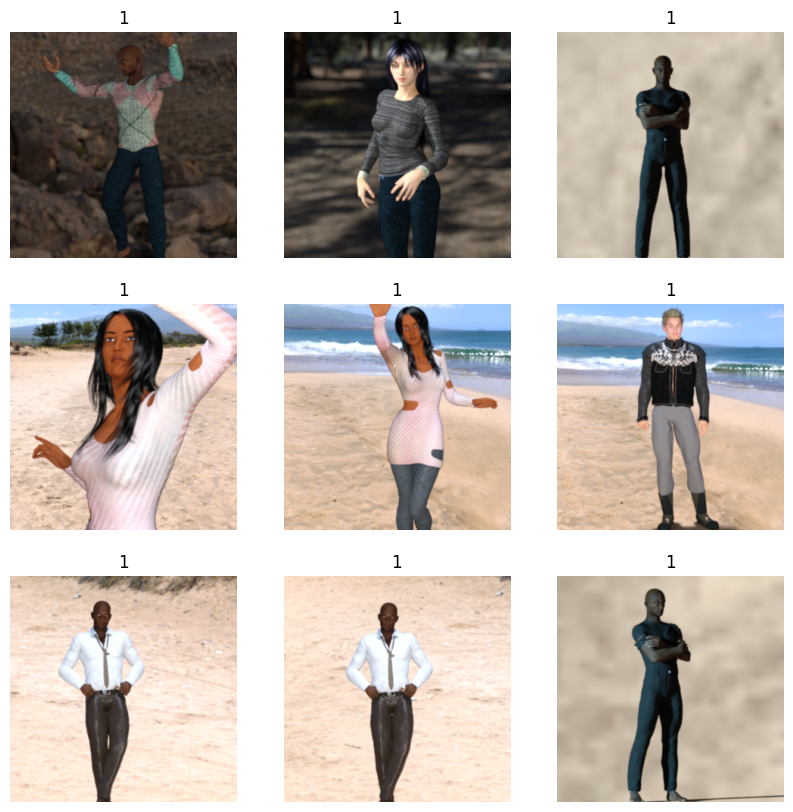

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, sample in enumerate(dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample["image"])
    plt.title(int(sample["label"]))
    plt.axis("off")

As mentioned above, we are only interested in the samples that correspond to the `humans` label.

## Extract conditioning images with MediaPipe

From the [official website](https://developers.google.com/mediapipe):

> MediaPipe offers open source cross-platform, customizable ML solutions for live and streaming media.

MediaPipe offers a bookeh of solutions that are particularly suitable for live and streaming media such as: selfie segmentation, face mesh, hand tracking, human pose estimation and tracking, etc. You can find out all the solutions supported by MediaPipe [here](https://developers.google.com/mediapipe/solutions/). 

We will use MediaPipe's APIs to extract pose body joints for ControlNet training.

ControlNet training expects the following:

* original images (like the ones above)
* corresponding conditioning images (segmented parts, pose estimation, Canny edges, etc.) 
* captions that describe the original images

In this example, we leverage [MediaPipe Pose Landmark Detection](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker) to extract pose estimated body points from the original images. Some other MediaPipe Solutions that are relevant for ControlNet training include [Face Landmark Detection](https://developers.google.com/mediapipe/solutions/vision/face_landmarker) and [Selfie Segmentation](https://developers.google.com/mediapipe/solutions/vision/image_segmenter).

For a detailed overview of how the ControlNet training workflow, refer to [this blog post](https://huggingface.co/blog/train-your-controlnet).

Below, we write utilities to extract the pose estimated body points and draw them on blank images to serve as our conditioning images.  

All MediaPipe Solutions Python API examples are under `mp.solutions`.

For the MediaPipe Pose solution, we can access this module as `mp_pose = mp.solutions.pose`.

You may change the parameters, such as `static_image_mode` and `min_detection_confidence`, during the initialization. Run `help(mp_pose.Pose)` to get more informations about the parameters. The official documentation for the `Pose` Python API is available [here](https://google.github.io/mediapipe/solutions/pose#python-solution-api).

In [3]:
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

 We define two important variables:

* `_JOINT_CMAP`: defines the body joint colors.
* `_CONNECTION_CMAP`: defines the connection (connection between the joints) colors. 

In [4]:
# MediaPipe Pose annotation for ControlNet.
from typing import Any
import numpy as np
import math
import cv2

# Body joint color map. #BGR
_JOINT_CMAP = {
    0: [0, 0, 255],
    1: [255, 208, 0],
    2: [255, 161, 0],
    3: [255, 114, 0],
    4: [0, 189, 255],
    5: [0, 236, 255],
    6: [0, 255, 226],
    7: [255, 0, 76],
    8: [0, 255, 131],
    9: [255, 0, 171],
    10: [0, 255, 37],
    11: [244, 0, 253],
    12: [57, 255, 0],
    13: [151, 0, 255],
    14: [151, 255, 0],
    15: [57, 0, 255],
    16: [245, 255, 0],
    17: [0, 39, 255],
    18: [255, 169, 0],
    19: [0, 133, 255],
    20: [255, 75, 0],
    21: [0, 228, 255],
    22: [255, 0, 19],
    23: [0, 255, 189],
    24: [255, 0, 113],
    25: [0, 255, 94],
    26: [255, 0, 208],
    27: [6, 255, 6],
    28: [207, 0, 255],
    29: [96, 255, 0],
    30: [112, 0, 255],
    31: [190, 255, 0],
    32: [23, 0, 255],
}


# Connection color map. #BGR
_CONNECTION_CMAP = {
    (0, 1): [127, 104, 127],
    (0, 4): [0, 94, 255],
    (1, 2): [255, 184, 0],
    (2, 3): [255, 137, 0],
    (3, 7): [255, 57, 38],
    (4, 5): [0, 212, 255],
    (5, 6): [0, 245, 240],
    (6, 8): [0, 255, 178],
    (9, 10): [127, 127, 104],
    (11, 12): [150, 127, 126],
    (11, 13): [197, 0, 254],
    (11, 23): [122, 127, 221],
    (12, 14): [104, 255, 0],
    (12, 24): [156, 127, 56],
    (13, 15): [104, 0, 255],
    (14, 16): [198, 255, 0],
    (15, 17): [28, 19, 255],
    (15, 19): [28, 66, 255],
    (15, 21): [28, 114, 255],
    (16, 18): [250, 212, 0],
    (16, 20): [250, 165, 0],
    (16, 22): [250, 127, 9],
    (17, 19): [0, 86, 255],
    (18, 20): [255, 122, 0],
    (23, 24): [127, 127, 151],
    (23, 25): [0, 255, 141],
    (24, 26): [255, 0, 160],
    (25, 27): [3, 255, 50],
    (26, 28): [231, 0, 231],
    (27, 29): [51, 255, 3],
    (27, 31): [98, 255, 3],
    (28, 30): [159, 0, 255],
    (28, 32): [115, 0, 255],
    (29, 31): [143, 255, 0],
    (30, 32): [67, 0, 255],
}

Next, we write a utility `draw_pose()` for:

* Extracting landmarks from the landmark_list and store landmarks' pixel values in a map.
* Computing the mouth center and shoulder center, which are not in thelandmark_list but are needed in pose annotation.
* Drawing the connections between landmarks.
* Drawing the pose landmarks.

In [ ]:
def draw_pose(
    image: np.ndarray,
    landmark_list: Any,
    connections: Any,
    overlay: bool = True,
) -> tuple[np.ndarray, dict[str, list[float]]]:
    """Draws the landmarks and the connections on the image.

    Args:
      image: A three channel BGR image represented as numpy ndarray.
      landmark_list: A normalized landmark list proto message to be annotated on
        the image.
      connections: A list of landmark index tuples that specifies how landmarks to
        be connected in the drawing.
      overlay: Whether to overlay on the input image.

    Returns:
      (image, dictionary).

    Raises:
      ValueError: If one of the following:
        a) If the input image is not three channel BGR.
        b) If any connetions contain invalid landmark index.
    """
    if image.shape[2] != mp_drawing._BGR_CHANNELS:
        raise ValueError("Input image must contain three channel bgr data.")
    image_rows, image_cols, _ = image.shape
    min_length = min(image_rows, image_cols)
    draw_line_width = math.floor(min_length * 0.01)
    draw_circle_radius = math.floor(min_length * 0.015)
    idx_to_coordinates = {}
    visibility = {}
    mouth_center, shoulder_center = [], []
    flattened_landmarks = {"coordinates": [], "visibility": []}

    for idx, landmark in enumerate(landmark_list.landmark):
        # Gets flattened landmarks as list.
        flattened_landmarks["coordinates"].extend(
            [round(landmark.x, 2), round(landmark.y, 2), round(landmark.z, 2)]
        )
        flattened_landmarks["visibility"].extend([round(landmark.visibility, 2)])

        # Loose threshold.
        if (
            landmark.HasField("visibility")
            and landmark.visibility < mp_drawing._VISIBILITY_THRESHOLD * 0.8
        ) or (
            landmark.HasField("presence")
            and landmark.presence < mp_drawing._PRESENCE_THRESHOLD * 0.8
        ):
            continue
        landmark_px = mp_drawing._normalized_to_pixel_coordinates(
            landmark.x, landmark.y, image_cols, image_rows
        )
        if landmark_px:
            idx_to_coordinates[idx] = landmark_px
            visibility[idx] = landmark.visibility

    if (
        mp_pose.PoseLandmark.MOUTH_LEFT in idx_to_coordinates
        and mp_pose.PoseLandmark.MOUTH_RIGHT in idx_to_coordinates
    ):
        for x, y in zip(
            idx_to_coordinates[mp_pose.PoseLandmark.MOUTH_LEFT],
            idx_to_coordinates[mp_pose.PoseLandmark.MOUTH_RIGHT],
        ):
            mouth_center.append((x + y) // 2)

    if (
        mp_pose.PoseLandmark.LEFT_SHOULDER in idx_to_coordinates
        and mp_pose.PoseLandmark.RIGHT_SHOULDER in idx_to_coordinates
    ):
        for x, y in zip(
            idx_to_coordinates[mp_pose.PoseLandmark.LEFT_SHOULDER],
            idx_to_coordinates[mp_pose.PoseLandmark.RIGHT_SHOULDER],
        ):
            shoulder_center.append((x + y) // 2)

    if overlay:
        output_image = image.copy()
    else:
        output_image = np.zeros(
            list(image.shape[:2])
            + [
                3,
            ],
            dtype=np.uint8,
        )

    if connections:
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    "Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
                cv2.line(
                    output_image,
                    pt1=idx_to_coordinates[start_idx],
                    pt2=idx_to_coordinates[end_idx],
                    color=_CONNECTION_CMAP[(start_idx, end_idx)],
                    thickness=draw_line_width,
                )

        # Draw mouth to neck
        if mouth_center and shoulder_center:
            cv2.line(
                output_image,
                pt1=tuple(mouth_center),
                pt2=tuple(shoulder_center),
                color=[255, 255, 255],
                thickness=draw_line_width,
            )

    # Draws landmark points after finishing the connection lines, which is
    # aesthetically better.
    for idx, landmark_px in idx_to_coordinates.items():
        # Fill color into the circle
        cv2.circle(
            output_image,
            center=landmark_px,
            radius=draw_circle_radius,
            color=_JOINT_CMAP[idx],
            thickness=-1,
        )

    return output_image, flattened_landmarks

## Map conditioning extraction

Since `dataset` is already a `tf.data.Dataset` we can write another utility to map over `dataset`. This utility will give us:

* the original image
* the body points overlaid on the original image
* the body points laid on a blank image

In [5]:
import tensorflow as tf


def determine_pose(image: tf.Tensor):
    """Estimates pose and creates an image with just the pose body points.

    The image consisting the pose body points serves as the conditioning image
    for ControlNet training.

    Args:
        image: A three channel RGB image represented as a tf.Tensor.

    Returns:
        A tuple consisting of the original image (`image`), an image where
        the original image is overlaid with the pose keypoints, and an image
        with just the pose keypoints.
    """
    image = image.numpy()

    # Run MediaPipe Pose and draw pose landmarks.
    with mp_pose.Pose(
        static_image_mode=True, min_detection_confidence=0.5, model_complexity=2
    ) as pose:
        # Process it with MediaPipe Pose.
        results = pose.process(image)

        # Draw pose landmarks on a copy of the input image.
        annotated_image, flattened_landmarks = draw_pose(
            image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS
        )

        # Draw pose landmarks on a blank image.
        blank_image, flattened_landmarks = draw_pose(
            image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, False
        )

    return image, annotated_image, blank_image

In [6]:
dataset = dataset.map(lambda x: x["image"], num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(
    lambda image: (
        tf.py_function(determine_pose, [image], [tf.uint8, tf.uint8, tf.uint8])
    )
)
dataset = dataset.apply(tf.data.experimental.ignore_errors())

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


## Visualize

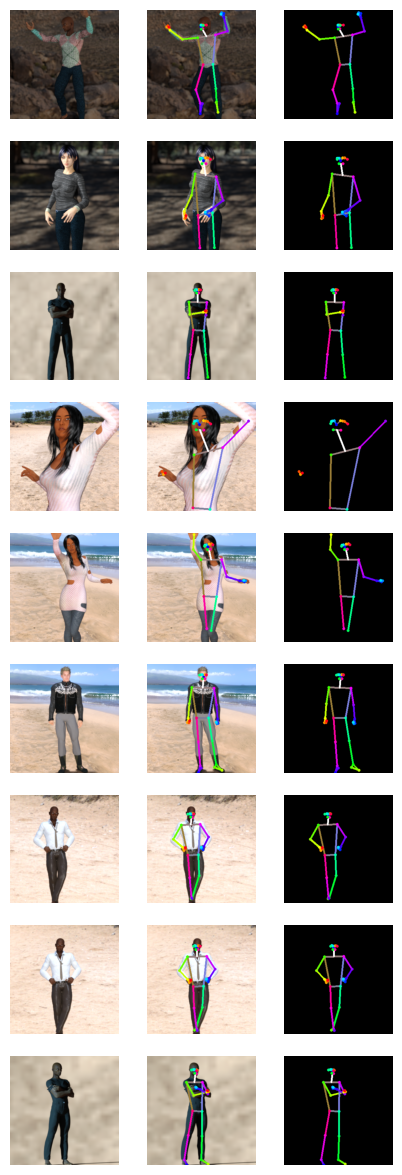

In [7]:
num_samples_to_vis = 9
fig, ax = plt.subplots(ncols=3, nrows=num_samples_to_vis, figsize=(5, 15))
for i, sample in enumerate(dataset.take(num_samples_to_vis).as_numpy_iterator()):
    original_image = sample[0]
    annotated_image, blank_image = sample[1], sample[2]

    samples = [original_image, annotated_image, blank_image]
    titles = ["Input", "Annotation Overlaid", "Annotation"]

    for j in range(3):
        ax[i, j].imshow(samples[j])
        ax[i, j].axis("off")

## Caption generation with BLIP-2

For this section, we leverage an open-source and powerful pre-trained model for caption generation - [BLIP-2](https://huggingface.co/papers/2301.12597). This model comes with [different checkpoints](https://huggingface.co/models?other=blip-2), among which we're using [Salesforce/blip2-flan-t5-xl](https://huggingface.co/Salesforce/blip2-flan-t5-xl). 

🤗 Transformers also supports its predecessor - [BLIP](https://huggingface.co/papers/2201.12086). 

In the cell below, we first load the following classes: `Blip2Processor` and `Blip2ForConditionalGeneration`. Then we write a utility to generate captions for a given batch of images. 


In [8]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
captioning_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-flan-t5-xl", torch_dtype=torch.float16
)
captioning_model = captioning_model.to(device)


def generation_captions(images: np.ndarray) -> list[str]:
    """Generates captions for a batch of images.

    Args:
        images: A batch of images in the RGB format.

    Returns:
        A list of generated captions.
    """
    inputs = processor(images=images, return_tensors="pt").to(device, torch.float16)

    generated_ids = captioning_model.generate(**inputs)
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
    generated_texts = [text.strip() for text in generated_texts]
    return generated_texts

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Generate captions and serialize

In this section, we first batch-generate captions and then we serialize the original images, and their corresponding conditioning images.

In [9]:
import os
import hashlib
import PIL

batch_size = 16
data_root = "data"
dataset = dataset.batch(batch_size, drop_remainder=True)

os.makedirs(data_root, exist_ok=True)


def save_image(
    original_image: np.ndarray,
    overlaid_annotation: np.ndarray,
    blank_annotation: np.ndarray,
):
    """Serializes images to `data_root`."""
    image_hash = hashlib.sha1(original_image.tobytes()).hexdigest()
    PIL.Image.fromarray(original_image).save(
        os.path.join(data_root, f"{str(image_hash)}_original.png")
    )
    PIL.Image.fromarray(overlaid_annotation).save(
        os.path.join(data_root, f"{str(image_hash)}_overlaid.png")
    )
    PIL.Image.fromarray(blank_annotation).save(
        os.path.join(data_root, f"{str(image_hash)}_condition.png")
    )
    return image_hash


original_image_paths = []
overlaid_annotation_paths = []
blank_annotation_paths = []
all_generated_captions = []
total = 0

for samples in dataset.as_numpy_iterator():
    original_images = samples[0]
    overlaid_annotations = samples[1]
    blank_annotations = samples[2]

    generated_captions = generation_captions(original_images)

    for i in range(len(original_images)):
        image_hash = save_image(
            original_images[i], overlaid_annotations[i], blank_annotations[i]
        )
        original_image_paths.append(
            os.path.join(data_root, f"{str(image_hash)}_original.png")
        )
        overlaid_annotation_paths.append(
            os.path.join(data_root, f"{str(image_hash)}_overlaid.png")
        )
        blank_annotation_paths.append(
            os.path.join(data_root, f"{str(image_hash)}_condition.png")
        )

        all_generated_captions.append(generated_captions[i])

    total += len(original_images)

print(f"{total} samples will go in the final dataset.")

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


496 samples will go in the final dataset.


## Create a 🤗 Dataset and push to the Hub

For this section, we leverage 🤗 Datasets to create a the final dataset that is ready to go with our [ControlNet training script](https://github.com/huggingface/diffusers/blob/main/examples/controlnet/train_controlnet_flax.py). 

Finally, we push the prepared dataset to Hub for easy sharing with the community. To be able to do that, you need to be a registered Hugging Face user to authenticate yourself. If you are not one already, please head over [hf.co](https://hf.co) and register youself; it's free =) 

In [12]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

We start with a generator that yields a tuple consisting of:

* `original_image`
* `condtioning_image`
* `overlaid`
* `caption`

Note that `overlaid` image is just there for convenience. It is not **mandatory** for us to include it while creating the dataset as it won't be used during training. 

In [13]:
def gen_examples():
    for i in range(len(original_image_paths)):
        yield {
            "original_image": {"path": original_image_paths[i]},
            "condtioning_image": {"path": blank_annotation_paths[i]},
            "overlaid": {"path": overlaid_annotation_paths[i]},
            "caption": all_generated_captions[i],
        }

In [14]:
from datasets import Dataset, Features
from datasets import Image as ImageFeature
from datasets import Value

final_dataset = Dataset.from_generator(
    gen_examples,
    features=Features(
        original_image=ImageFeature(),
        condtioning_image=ImageFeature(),
        overlaid=ImageFeature(),
        caption=Value("string"),
    ),
    num_proc=8,
)

ds_name = "poses-controlnet-dataset"
final_dataset.push_to_hub(ds_name)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset generator downloaded and prepared to /root/.cache/huggingface/datasets/generator/default-c340e697ab6fb52e/0.0.0. Subsequent calls will reuse this data.


Map:   0%|          | 0/496 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
len(original_image_paths), len(blank_annotation_paths), len(overlaid_annotation_paths), len(all_generated_captions)

(496, 496, 496, 496)

Refer to [`from_generator()` documentation](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.from_generator) to know more about it. 

Note that, you can specify `private=True` in `push_to_hub` to host the dataset privately. 

After the dataset is pushed, it will look like so:

![](https://i.imgur.com/Xi6iLal.png)

You can find the final dataset here: [sayakpaul/poses-controlnet-dataset](https://huggingface.co/datasets/sayakpaul/poses-controlnet-dataset). 

We can now successfully train a ControlNet model. Refer to [this section](https://github.com/huggingface/diffusers/tree/main/examples/controlnet#training-with-flaxjax) for more details. 